# Simple linear regression on Python

In [3]:
import folium

m = folium.Map(location=(54.6872, 25.2797), zoom_start=10)

m

In [78]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

%matplotlib inline

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 12


# sklearn
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

np.random.seed(0)

## Data preparation

__Reading data__

Due to significant size of `df` I will use `polars` instead of `pandas`, also applying `polars` feature to recognize datetime columns

In [5]:
df = pl.read_csv('train.csv', try_parse_dates = True)
df.head()

id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
str,i64,datetime[μs],datetime[μs],i64,f64,f64,f64,f64,str,i64
"""id2875421""",2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.96463,40.765602,"""N""",455
"""id2377394""",1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,"""N""",663
"""id3858529""",2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,"""N""",2124
"""id3504673""",2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.01004,40.719971,-74.012268,40.706718,"""N""",429
"""id2181028""",2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.78252,"""N""",435


Check null values

In [6]:
sum(df.select(pl.all().is_null().sum()) )

id
u32
0


Dropping excess column (is present in the train data, but not in the testing)

In [7]:
df = df.drop(['dropoff_datetime'])

Studying the target's distribution

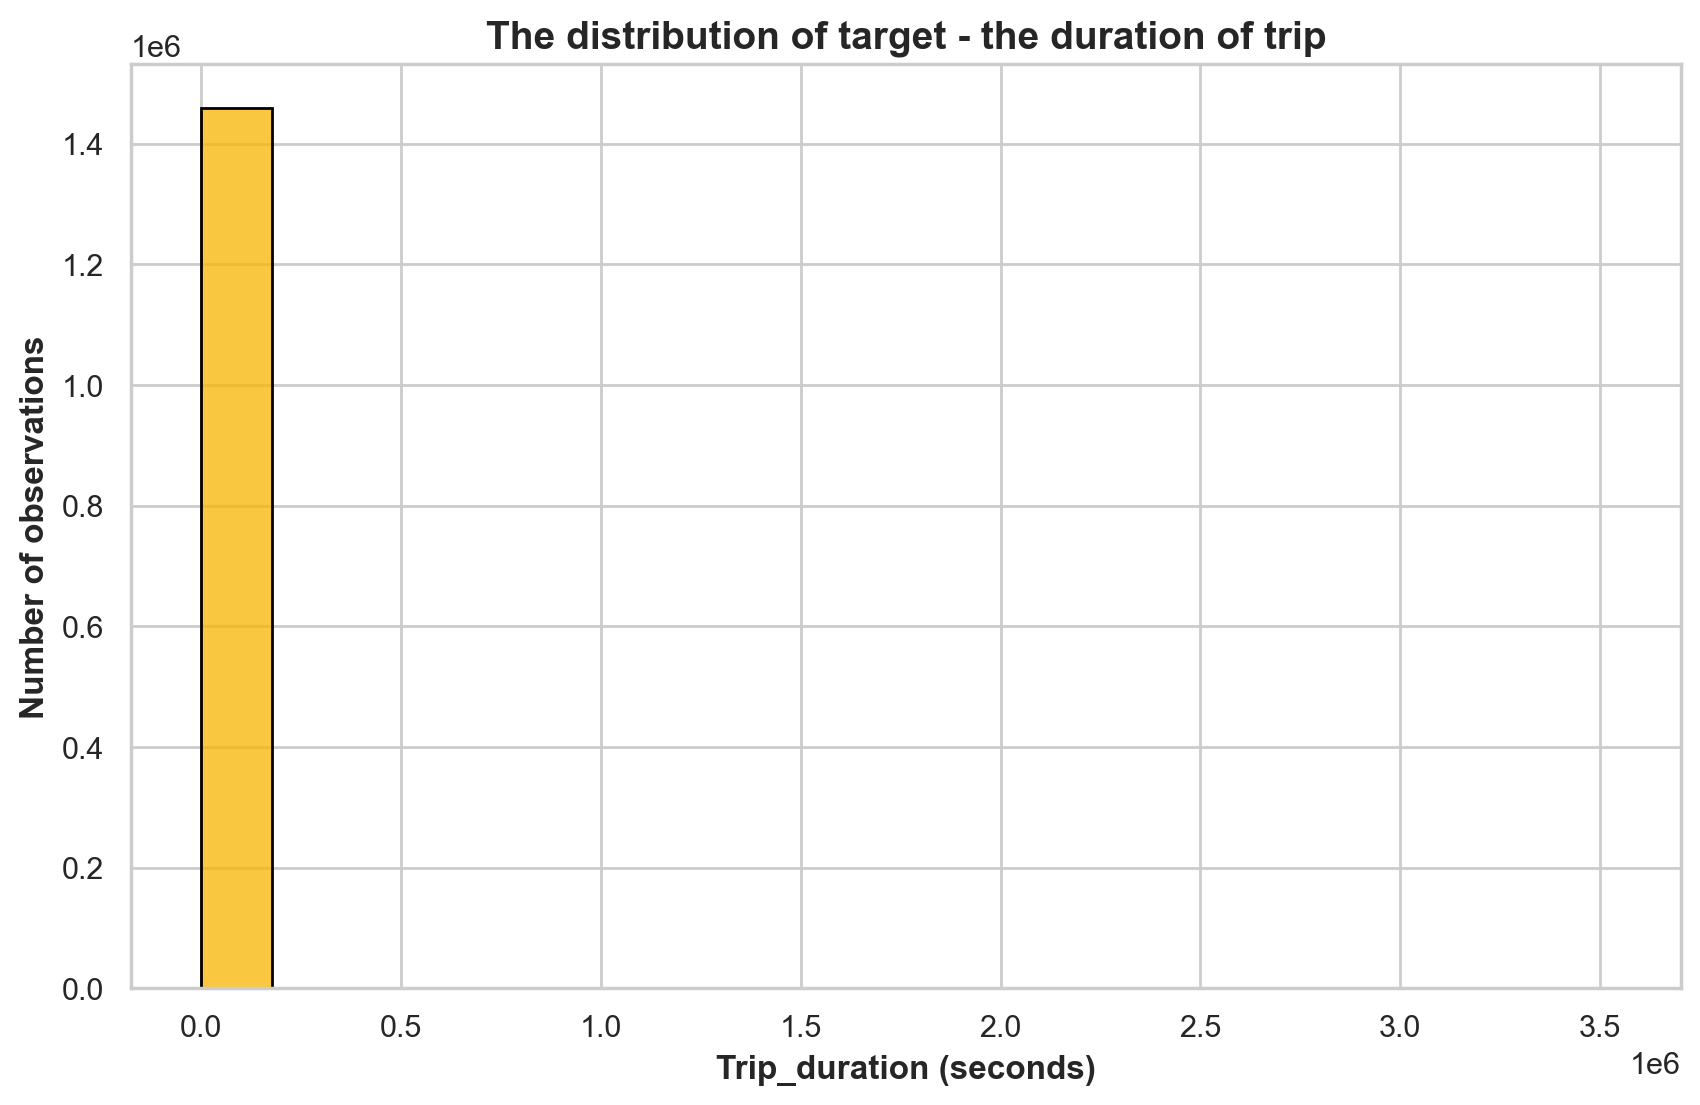

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('The distribution of target - the duration of trip', fontsize=14,fontweight="bold")

plt.xlabel('Trip_duration (seconds)',  fontsize=12, fontweight="bold")
plt.ylabel('Number of observations',  fontsize=12, fontweight="bold")
sns.histplot( x =df['trip_duration'].to_list() ,ax = ax, edgecolor = 'black', color = '#f8b500' , bins = 20);

As we see, distribution is quite far from normal, left-skewed. 

In order to rectify the situation I propose to take logarithm.

In [9]:
df = df.with_columns(np.log1p(df['trip_duration']).alias('log_trip_duration'))

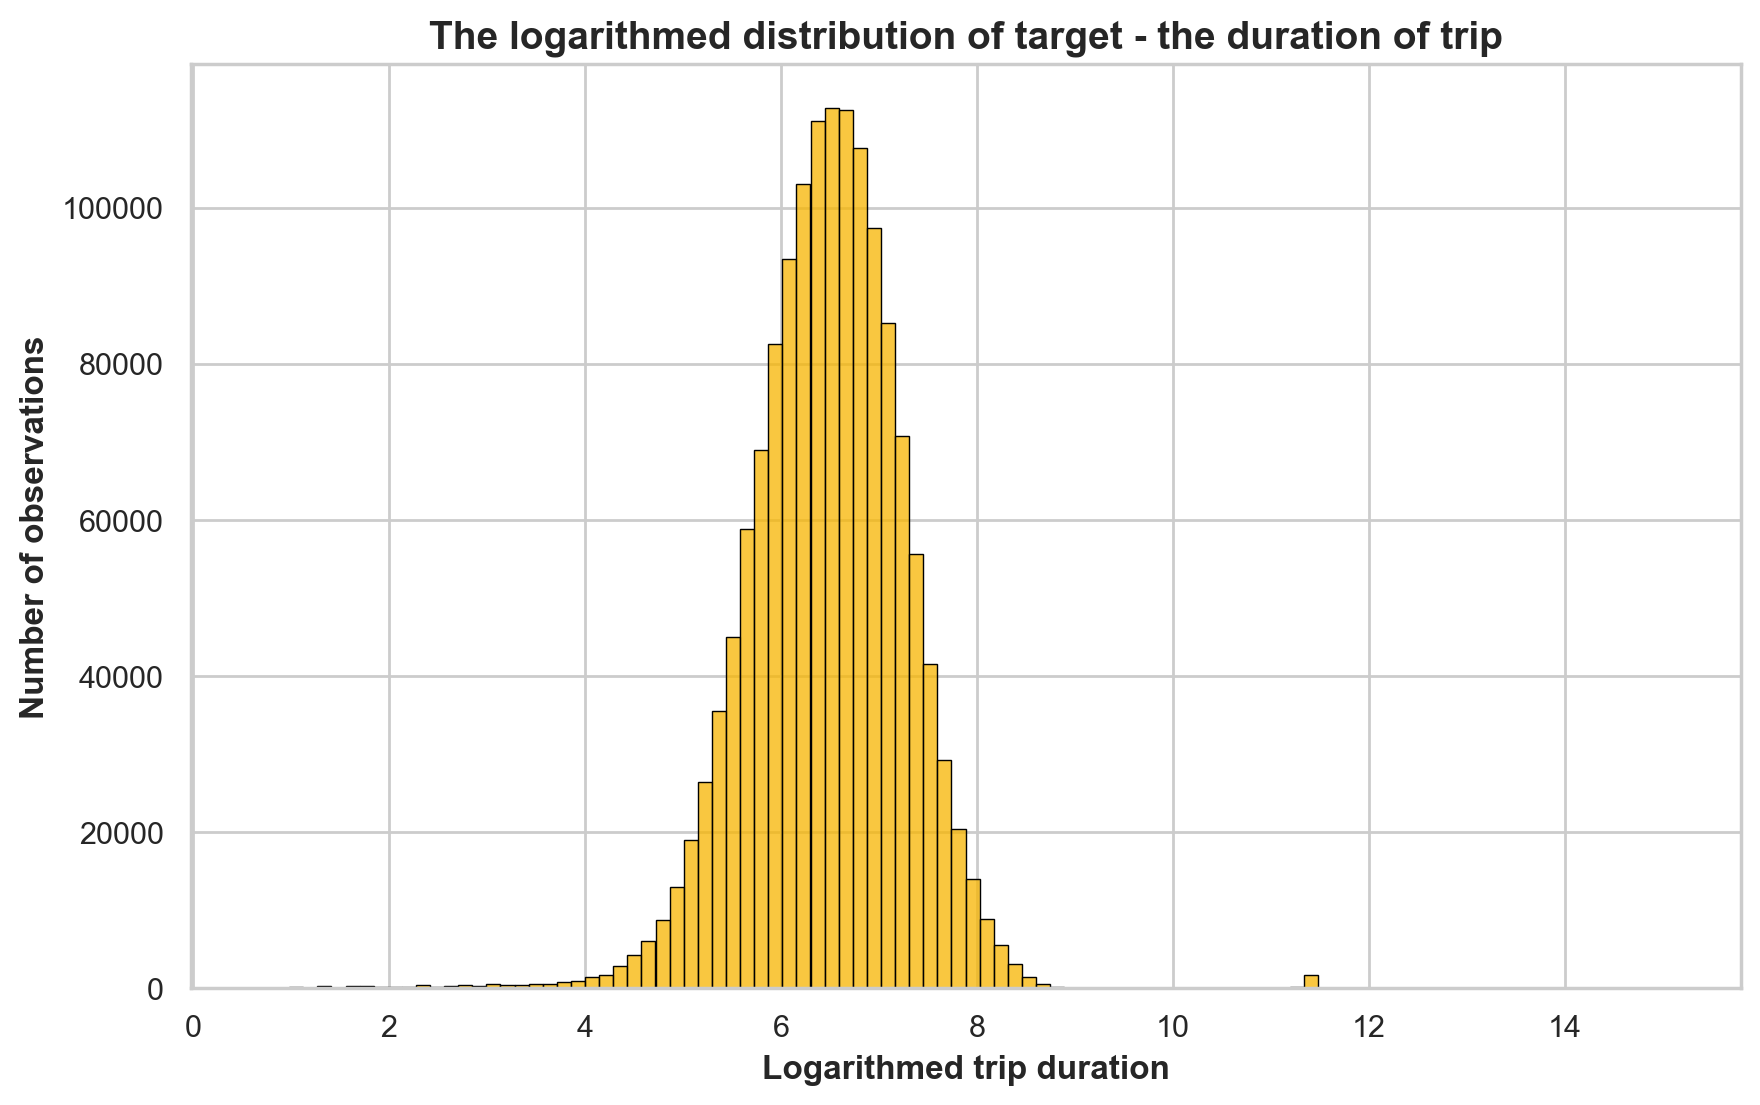

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title('The logarithmed distribution of target - the duration of trip', fontsize=14,fontweight="bold")

plt.xlabel('Logarithmed trip duration',  fontsize=12, fontweight="bold")
plt.ylabel('Number of observations',  fontsize=12, fontweight="bold")
sns.histplot( x =df['log_trip_duration'].to_list() ,ax = ax, edgecolor = 'black', color = '#f8b500' , bins = 100);

Now it looks significanlty better. 

In [11]:
df.shape[0]

1458644

The metrics chosen for the competition is RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

Is fair so long as
 - Trip's duration is measured in seconds, whereas we are more interested in a larger scale - mintures
 - The major goal is rather predicting the the order of time (logarithm comes very handy)
 - Metrics penalizes for lowered prediction (less time). For taxi being late is worser than arriving before time

Now let's prove that RMSLE optimization for model $a$ is equal to MSE optimization for model $\hat{a}$.

**Proving**: 
$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2} = \text{RMSE} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}=\sqrt{\text{MSE}\big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}} = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell}\big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}=\text{RMSLE}\big(\hat{y}_i,\hat{a}(x_i) \big)$

Identifying baseline

In [44]:
constant_vector = np.repeat(np.mean(df['log_trip_duration'].to_list() ), df.shape[0] )
rmsle_best_const =  mean_squared_error( constant_vector ,df['log_trip_duration'], squared=False) 
print(rmsle_best_const)
print("If the RMSLE is larger than  {},then ml model is worser than a constant prediction"\
.format(round(rmsle_best_const, 4) ) )

0.7957592365411509
If the RMSLE is larger than  0.7958,then ml model is worser than a constant prediction


## Exploring `pickup_datetime`

In [45]:
import datetime

In [46]:
len(df['id'])

1458644

In [47]:
df = df.with_columns(
    pl.col("pickup_datetime").cast(pl.Date).alias('pickup_date')
)

In [48]:
date_count = df.groupby('pickup_date').count().sort('pickup_date')

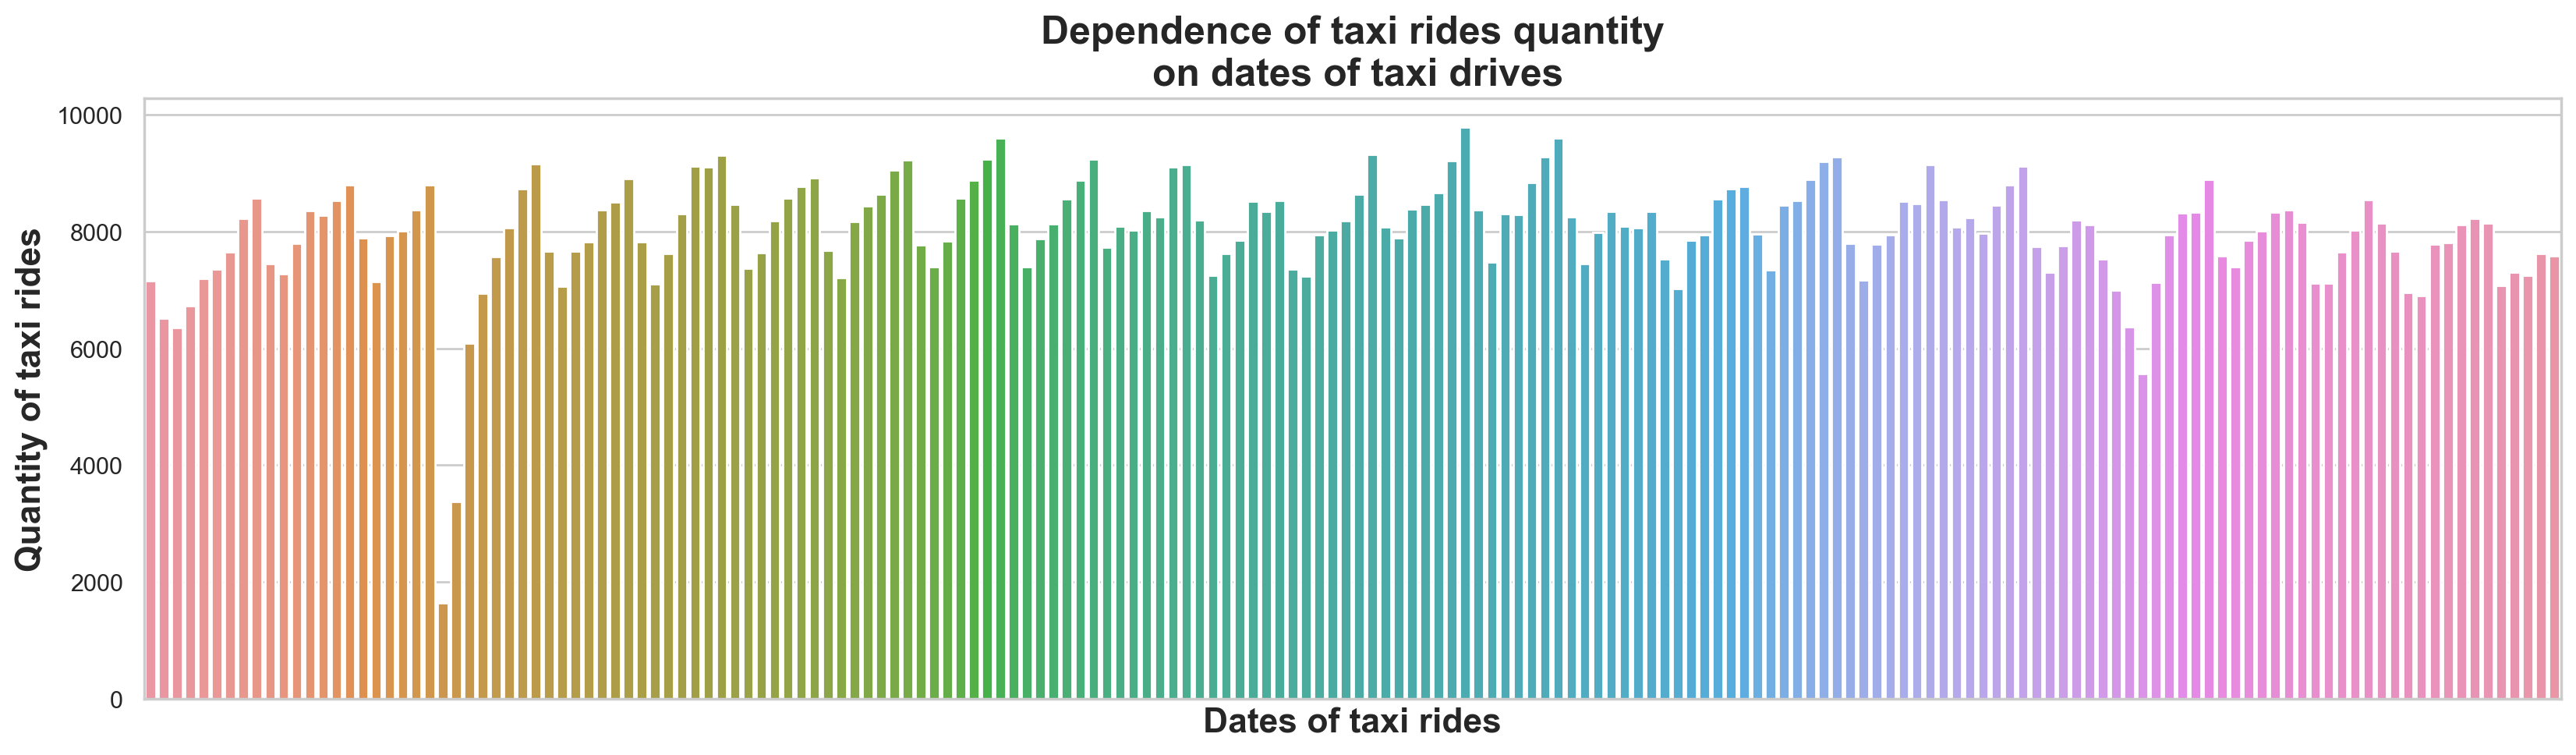

In [49]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title('Dependence of taxi rides quantity\n on dates of taxi drives', fontsize=18, fontweight ='bold')

sns.barplot( x = list(date_count['pickup_date']),
            y = list(date_count['count']),
            ax = ax );

plt.xlabel('Dates of taxi rides', fontsize=16, fontweight ='bold')
plt.ylabel('Quantity of taxi rides', fontsize=16, fontweight ='bold')
plt.xticks([]);

Certain patterns or loops can be observed  - we can see approximatelly 26 "hills" -  when quantity grows, reaches its maximum and subsequenlty decreases. 

Let's also see dates when taxi rides in NYC reached its minimum. 

In [50]:
date_count.sort("count").head()

pickup_date,count
date,u32
2016-01-23,1648
2016-01-24,3383
2016-05-30,5570
2016-01-25,6084
2016-01-03,6353


After little googling I found out:
 -  [2016.01.23 - 2016.01.25](https://www.usatoday.com/story/weather/2016/01/23/blizzard-continues-slam-east-coast/79217258/) Snowstorms in NYC , taxi rides were prohibited
 -  [2016.05.29 - 2016.05.30](https://www.govinfo.gov/features/memorial-day-2016#:~:text=Memorial%20Day%2C%20Monday%2C%20May%2030,the%20last%20Monday%20in%20May.) The Memorial day (the end of May in 2016)

In [51]:
import datetime as dt

In [52]:
df = df.with_columns(
    pl.col("pickup_date").dt.weekday().alias("weekday"),
    pl.col("pickup_date").dt.ordinal_day().alias("day_of_year"),
    pl.col("pickup_date").dt.month().alias("month"),
    pl.col("pickup_datetime").dt.hour().alias("hour"),
)

In [53]:
np.arange(1,7)

array([1, 2, 3, 4, 5, 6])

<Figure size 1000x600 with 0 Axes>

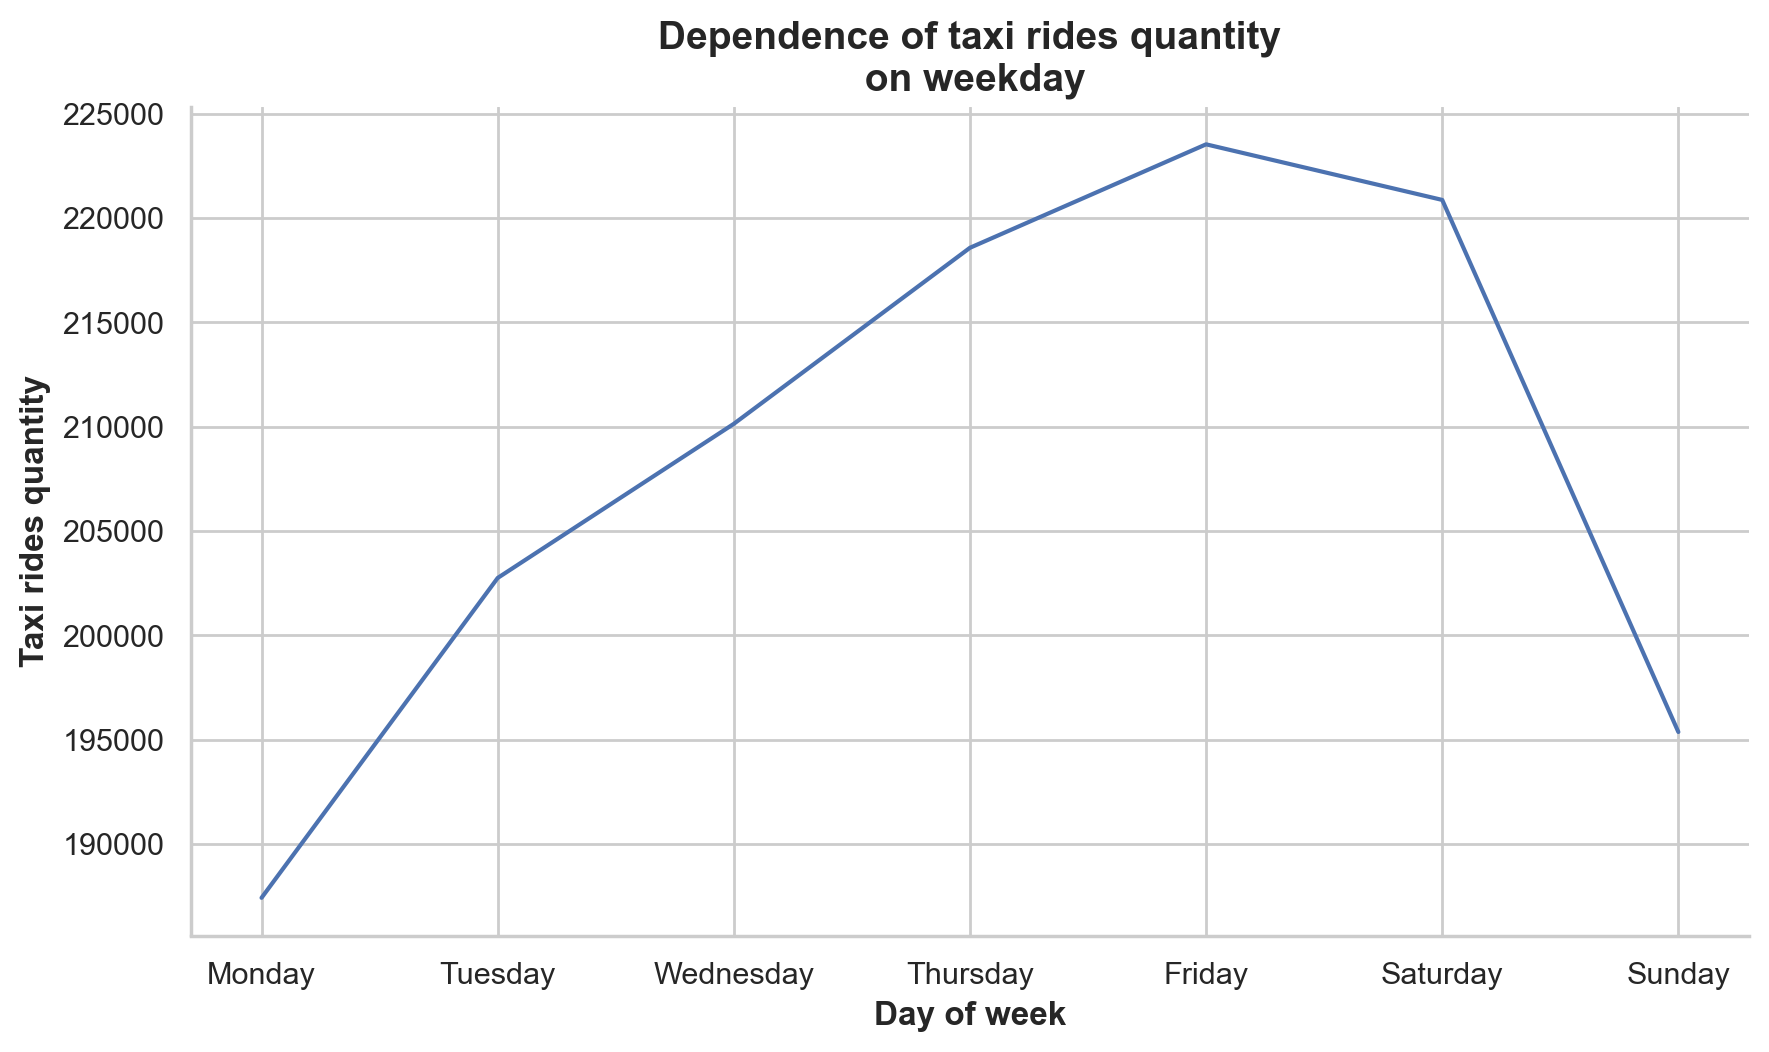

In [54]:
trips_day = df.groupby('weekday').count()

plt.figure(figsize=(10,6))
sns.relplot(x = trips_day['weekday'].to_list(), y =trips_day['count'].to_list() ,
            kind= 'line', height=5,  aspect=1.8);
plt.title('Dependence of taxi rides quantity\n on weekday', fontsize=14, fontweight ='bold')
plt.xlabel('Day of week', fontsize=12,  fontweight ='bold')
plt.ylabel('Taxi rides quantity', fontsize=12, fontweight ='bold')
plt.xticks(np.arange(1,8), labels=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] )
plt.show();

Interesting pattern, with the quantity of taxi rides growing until Friday (it is a peack)

In [55]:
trips_hour = df.groupby('hour').count()
trips_hour.sort('count', descending = True)

hour,count
i8,u32
18,90600
19,90308
21,84185
20,84072
22,80492
17,76483
14,74292
12,71873
15,71811


<Figure size 1000x600 with 0 Axes>

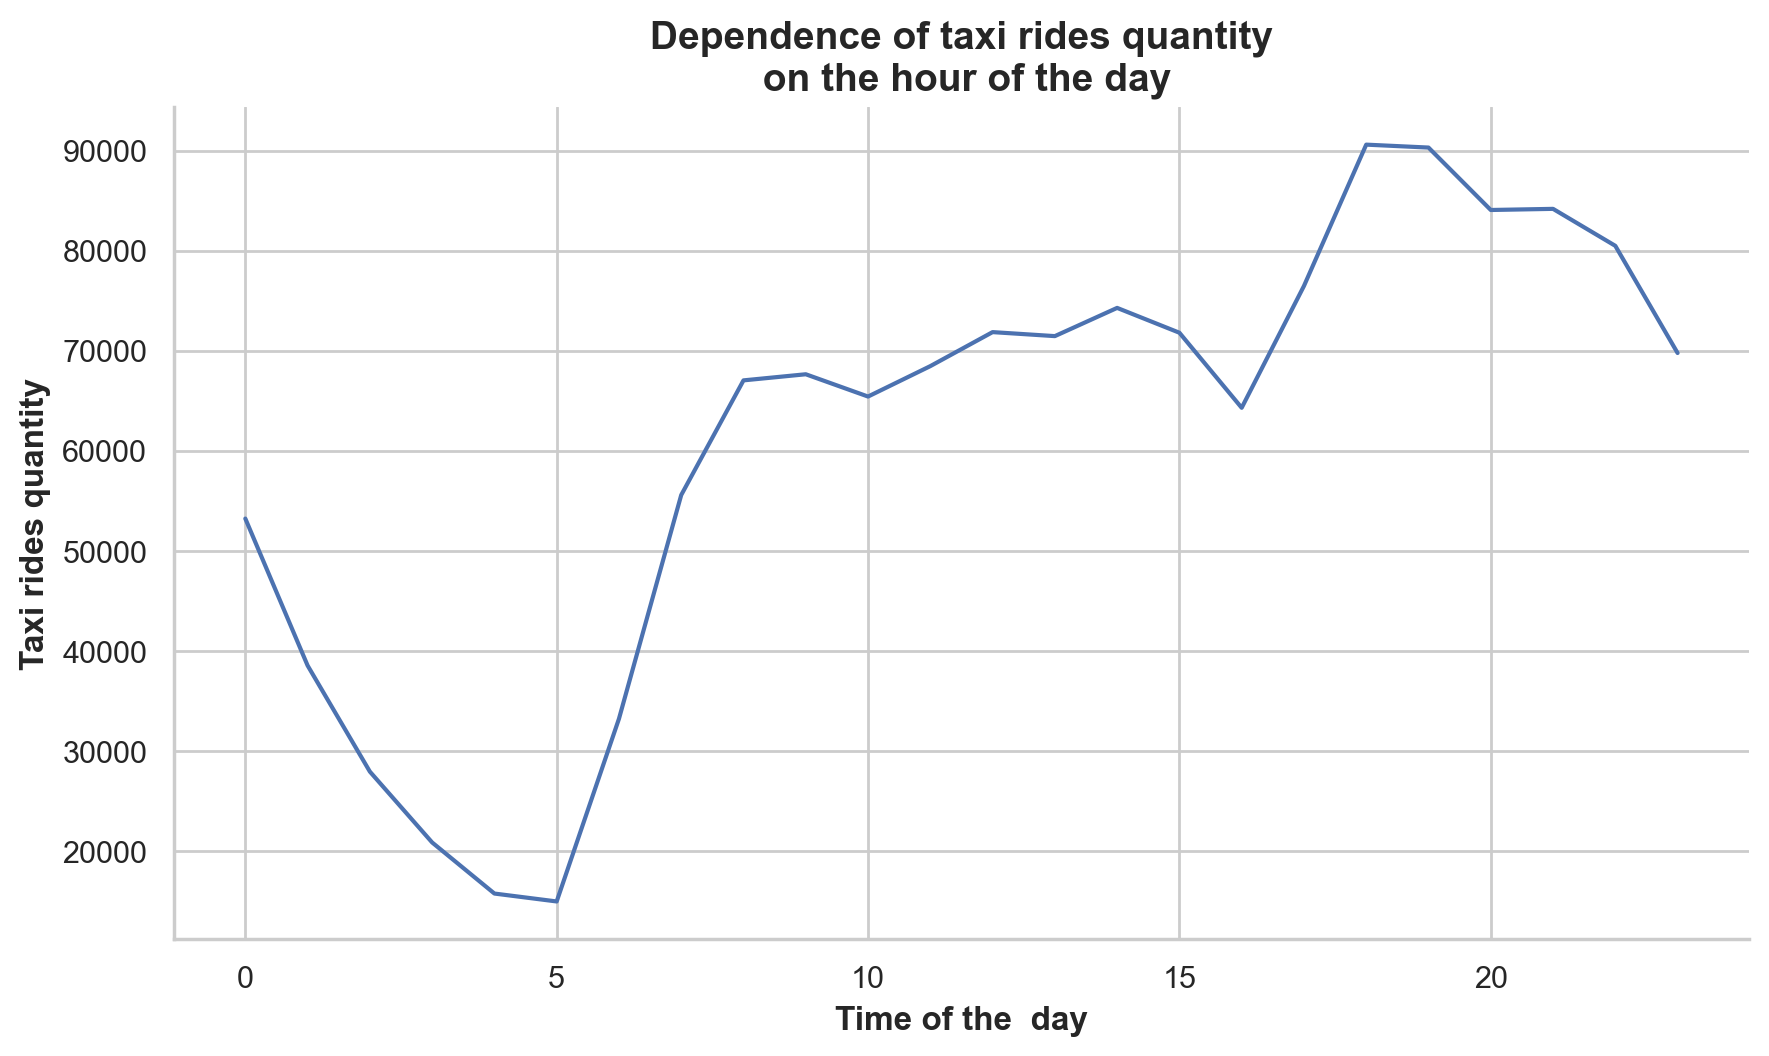

In [56]:
plt.figure(figsize=(10,6))
sns.relplot(x= trips_hour['hour'], y = trips_hour['count'],
     kind= 'line', height=5,  aspect=1.8)
plt.title('Dependence of taxi rides quantity\n on the hour of the day', fontsize=14, fontweight ='bold')
plt.xlabel('Time of the  day', fontsize=12,  fontweight ='bold')
plt.ylabel('Taxi rides quantity', fontsize=12, fontweight ='bold')
plt.show()

In [57]:
palette_months =['#e6194b', '#3cb44b', '#e6194B', '#4363d8', '#f58231', '#911eb4']
palette_days =['#e6194b', '#3cb44b', '#e6194B', '#4363d8', '#f58231', '#911eb4', '#f032e6']

[Source](https://sashamaps.net/docs/resources/20-colors/) of contrasting colors

In [58]:
df.groupby(['month', 'hour']).count().head()

month,hour,count
i8,i8,u32
1,22,12232
5,7,9471
1,12,11272
1,17,12538
3,0,8992


<Figure size 1000x600 with 0 Axes>

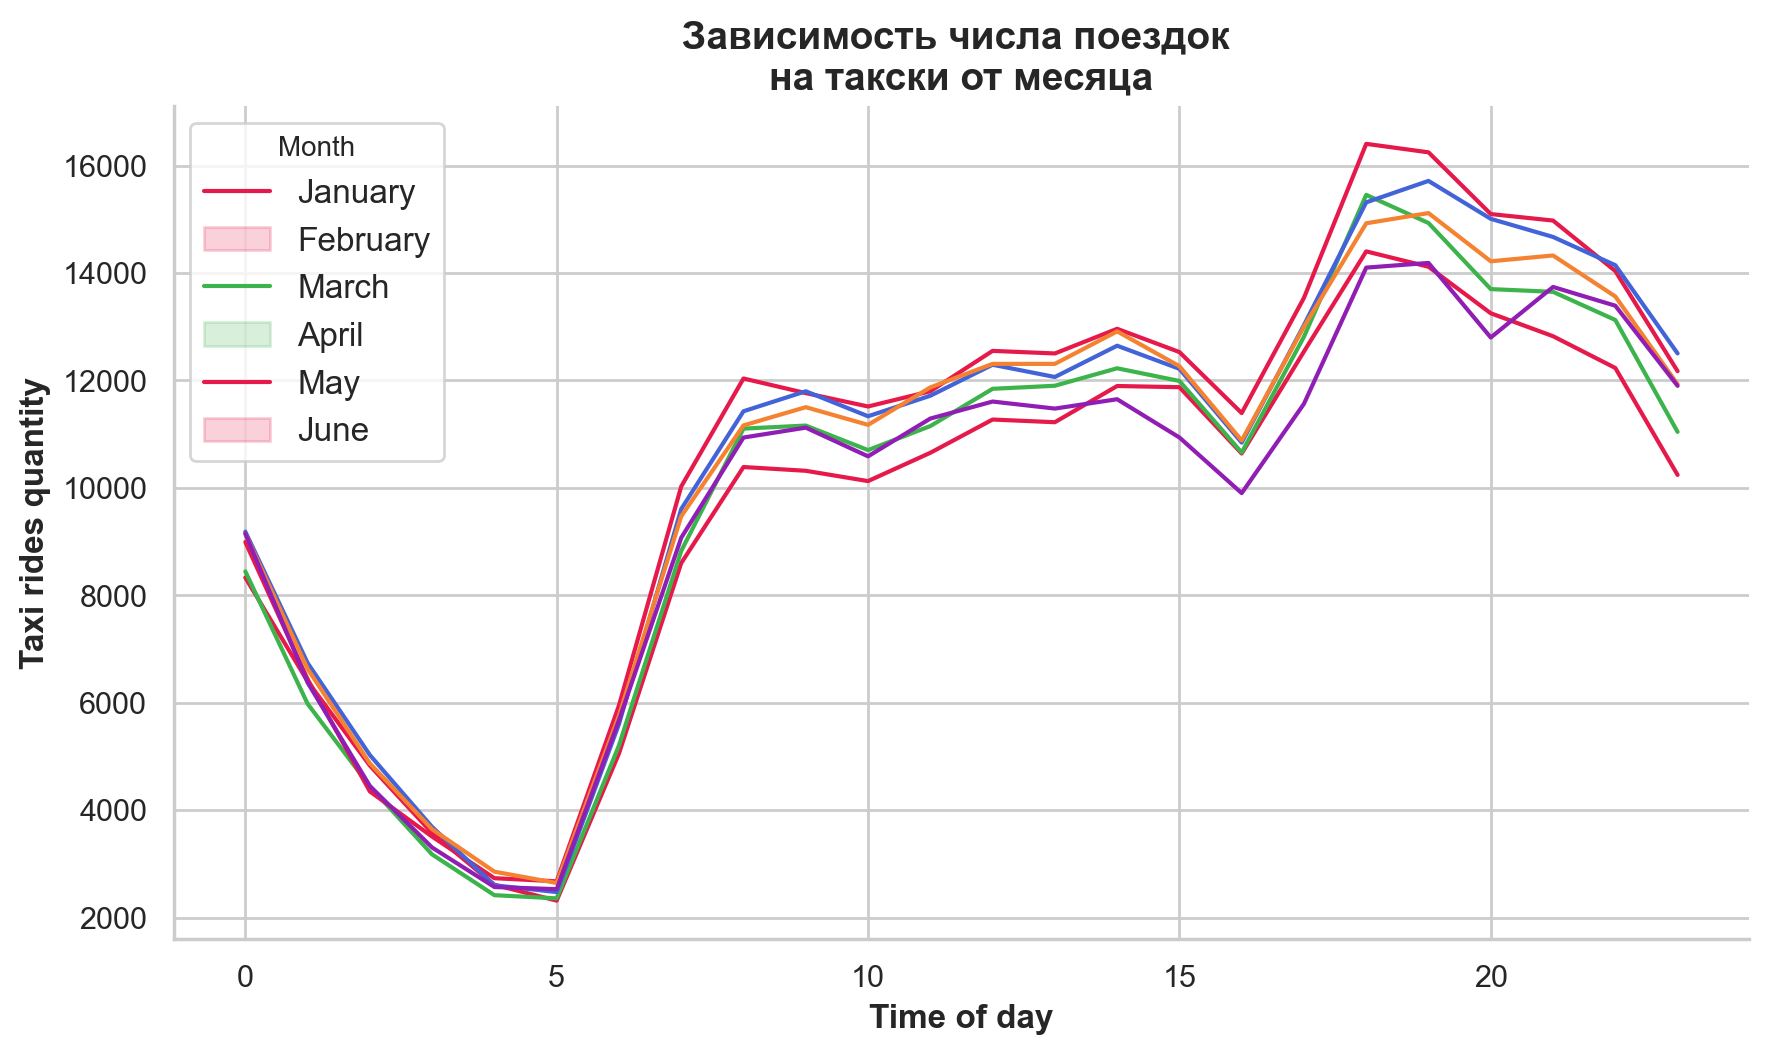

In [59]:
months = df.groupby(['month', 'hour']).count()
plt.figure(figsize=(10,6))
sns.relplot(x= months['hour'], y = months['count'],
     kind= 'line',hue = months['month'], height=5,  aspect=1.8, legend = False,
            palette = palette_months)
plt.title('Зависимость числа поездок \nна такски от месяца', fontsize=14, fontweight ='bold')
plt.xlabel('Time of day', fontsize=12,  fontweight ='bold')
plt.ylabel('Taxi rides quantity', fontsize=12, fontweight ='bold')
plt.legend(title='Month', labels=['January', 'February', 'March', 'April', 'May', 'June'], title_fontsize=10, fontsize=12
         )
plt.show();

In [64]:
df.groupby('day_of_year').count().sort('count').head()

day_of_year,count
i16,u32
23,1648
24,3383
151,5570
25,6084
3,6353


In [65]:
anomalous_dates = [23, 24,   151]

In [128]:
df = df.with_columns(
    pl.when(pl.col('day_of_year').is_in(anomalous_dates)  ).then(pl.lit(1))
    
    .otherwise(pl.lit(0))
    .alias('anomalous_date')
)

In [131]:
df.columns

['id',
 'vendor_id',
 'pickup_datetime',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'store_and_fwd_flag',
 'trip_duration',
 'log_trip_duration',
 'pickup_date',
 'weekday',
 'day_of_year',
 'month',
 'hour',
 'anomalous_date']

In [130]:
df[numeric +  categorical +target].to_pandas()

,day_of_year,anomalous_date,weekday,month,hour,log_trip_duration
0,74,0,1,3,17,6.122493
1,164,0,7,6,0,6.498282
2,19,0,2,1,11,7.661527
3,97,0,3,4,19,6.063785
4,86,0,6,3,13,6.077642
...,...,...,...,...,...,...
1458639,99,0,5,4,13,6.658011
1458640,10,0,7,1,7,6.486161
1458641,113,0,5,4,6,6.639876
1458642,5,0,2,1,15,5.924256


In [150]:
categorical = ['anomalous_date', 'weekday', 'month', 'hour', 'day_of_year' ]
numeric = ['day_of_year']
target = ['log_trip_duration']
X_train, X_test = train_test_split(df[ numeric+  categorical +target].to_pandas(), 
                                   train_size=0.7, test_size=0.3, random_state=42)

y_train = X_train['log_trip_duration']
y_test = X_test['log_trip_duration']

X_train = X_train.drop('log_trip_duration', axis=1)
X_test = X_test.drop('log_trip_duration', axis=1)

In [154]:
transform_column = ColumnTransformer([
    ('encoding', OneHotEncoder(), categorical),
    ('scaling',  StandardScaler(), numeric)
])

In [155]:
pipeline = Pipeline(steps=([
    ('encoding_and_scaling', transform_column),
    ('regression', Ridge(random_state = 42))
]))

In [156]:
%%time
model = pipeline.fit(X_train, y_train)
pred_test = model.predict(X_test)
pred_train = model.predict(X_train)

rmse_test = mean_squared_error(pred_test, y_test, squared=False)
rmse_train = mean_squared_error(pred_train, y_train, squared=False)
print(f'RMSLE on  test: {round(rmse_test, 5)}, \nRMSLE on train: {round(rmse_train, 5)}')

RMSLE on  test: 0.78713, 
RMSLE on train: 0.78796
CPU times: total: 7.94 s
Wall time: 3.25 s


In [ ]:
RMSLE on  test: 0.78824, 
RMSLE on train: 0.78916

## Exploring coordinates

In [40]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """
    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)
    for  row in data.iter_rows():
        folium.Circle(
            radius=100,
            location=(row[5], row[6]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [41]:
show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [42]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [65]:
df = df.with_columns(haversine_array(df['pickup_latitude'], df['pickup_longitude'],
                                         df['dropoff_latitude'], df['dropoff_longitude']).alias('haversine') )
df= df.with_columns(np.log1p(df['haversine']).alias('log_haversine'))

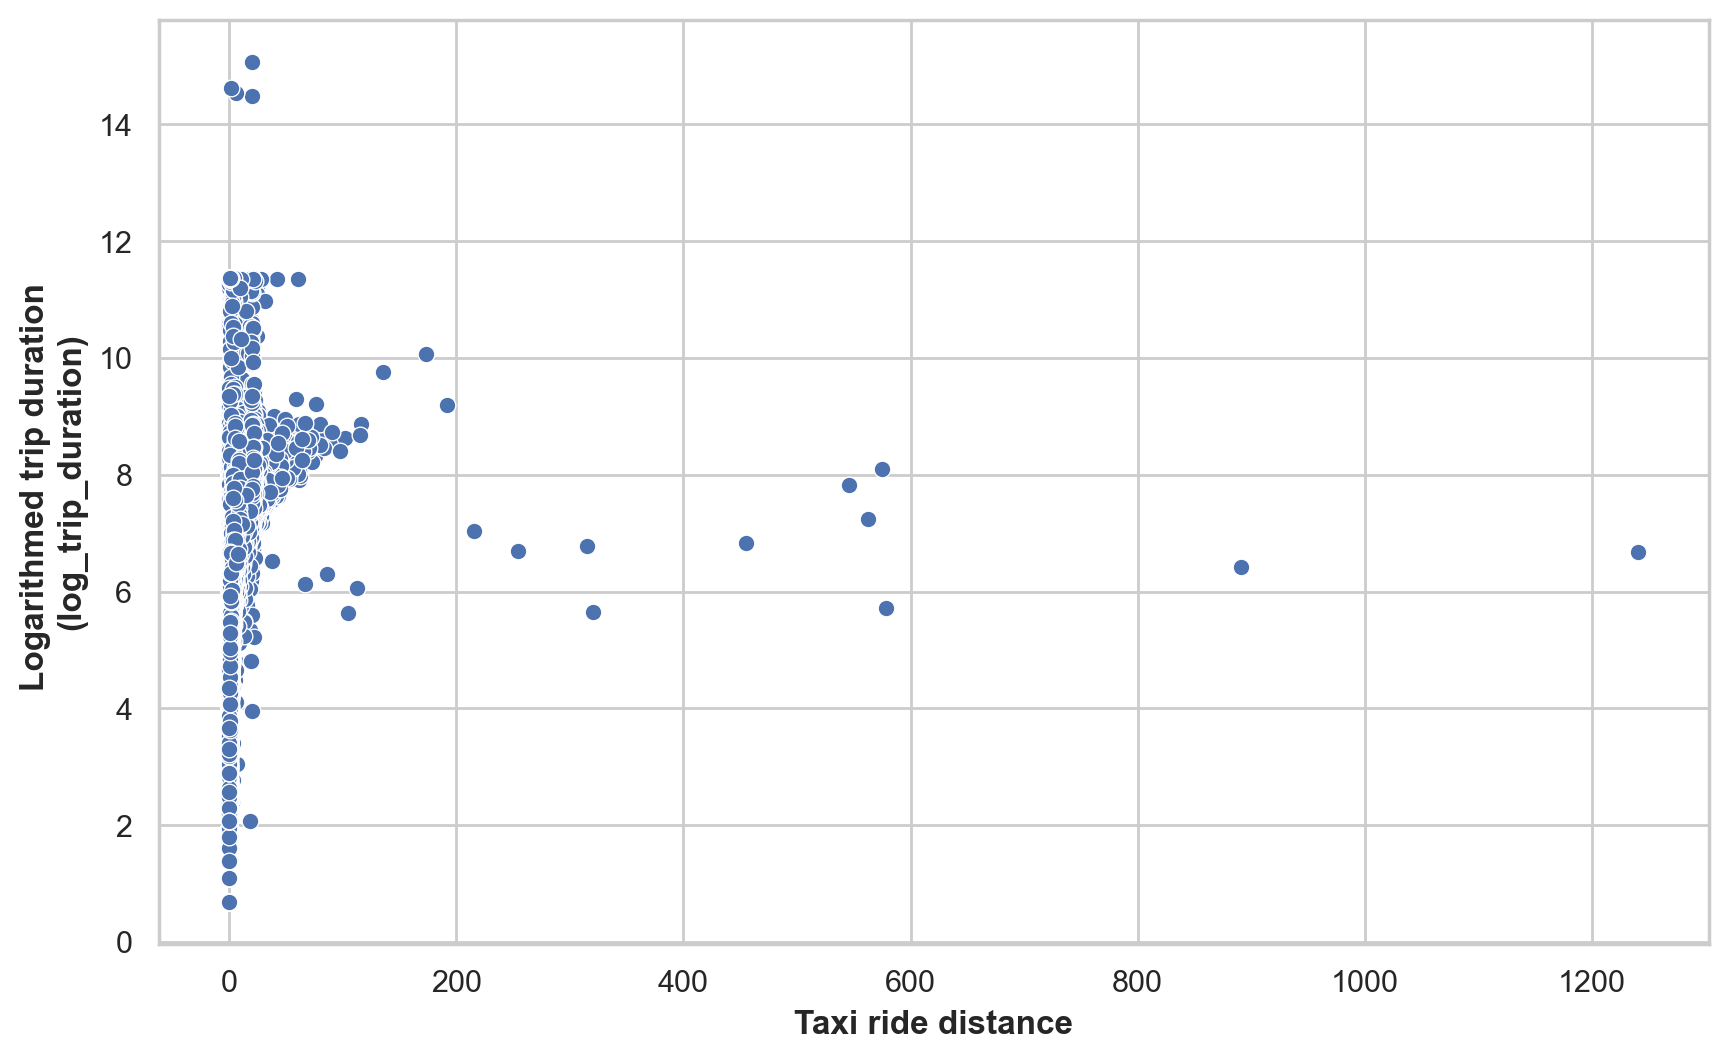

In [66]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.xlabel('Taxi ride distance', fontsize=12, fontweight ='bold');
plt.ylabel('Logarithmed trip duration \n(log_trip_duration)', fontsize=12, fontweight ='bold');
sns.scatterplot( x =df['haversine'].to_list()
                , y=df['log_trip_duration'].to_list(),ax = ax);

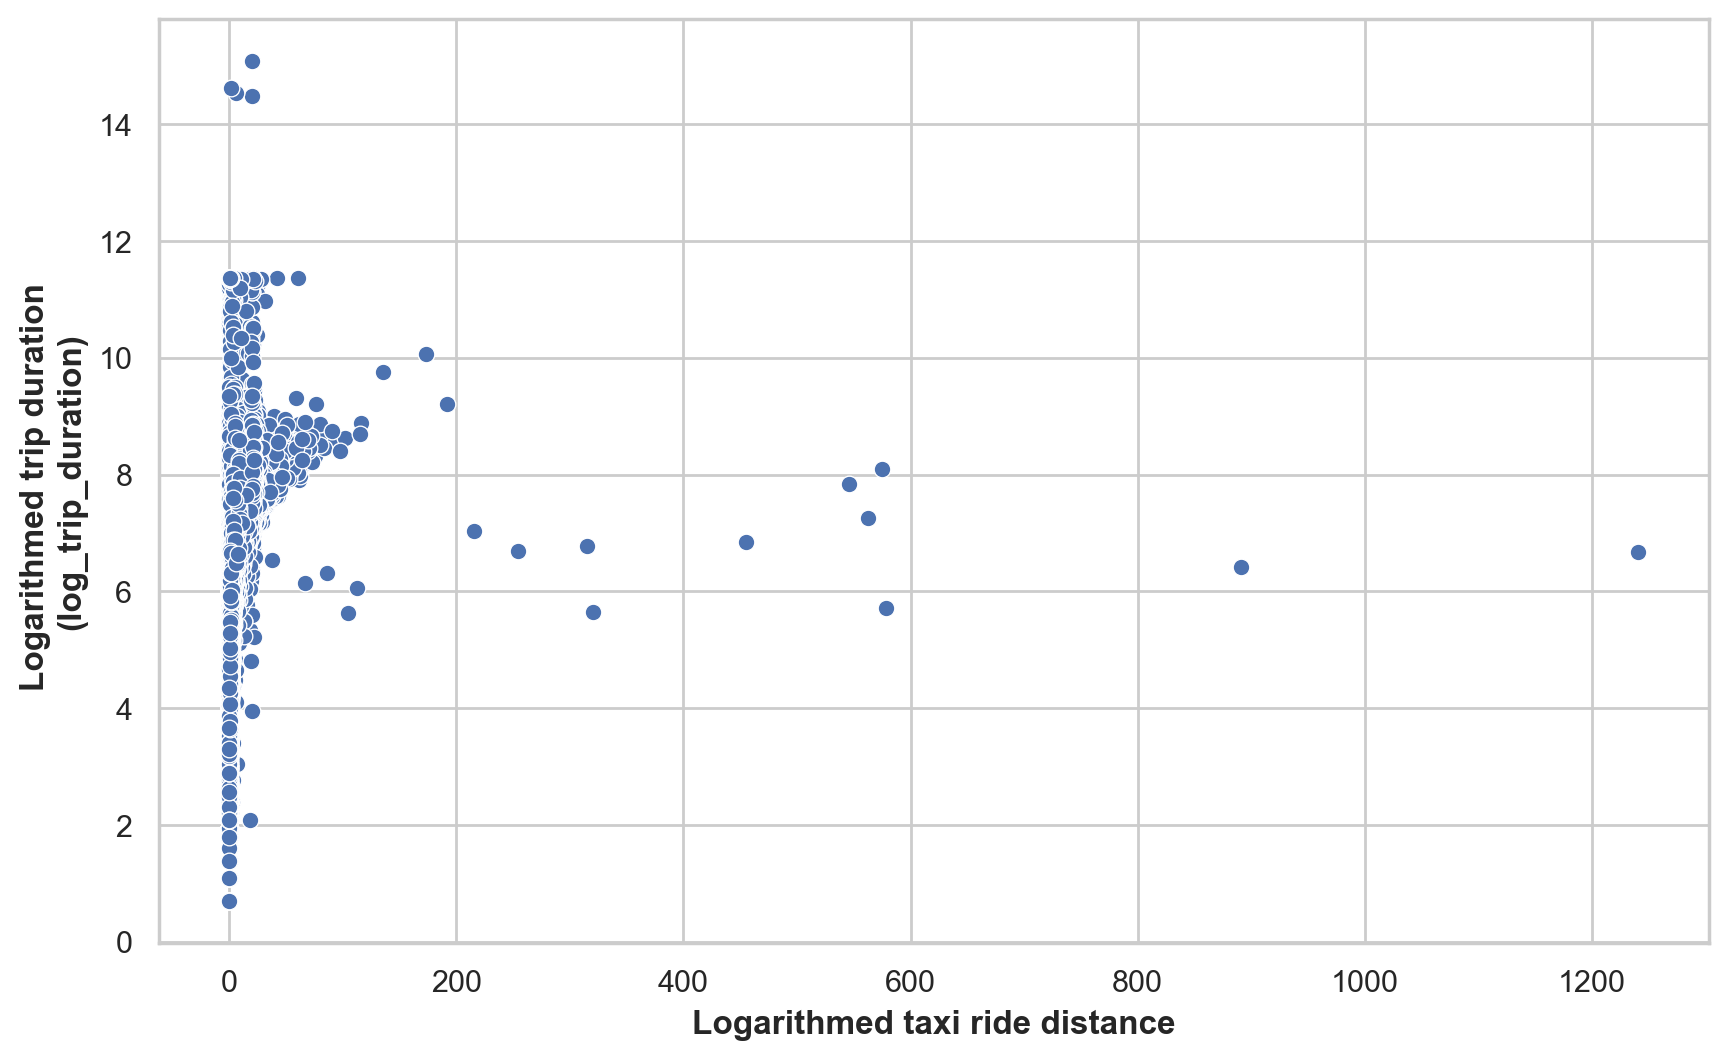

In [67]:
fig, ax = plt.subplots(figsize=(10, 6))
plt.xlabel('Logarithmed taxi ride distance', fontsize=12, fontweight ='bold');
plt.ylabel('Logarithmed trip duration \n(log_trip_duration)', fontsize=12, fontweight ='bold');
sns.scatterplot( x =df['haversine'].to_list()
                , y=df['log_trip_duration'].to_list(),ax = ax);

## Other features

## Improving model